<a href="https://colab.research.google.com/github/RamonCz/ReconocimientoTumores/blob/main/Proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sistema de reconocimiento de objetos en imágenes**

En este proyecto se relizará reconocmiento de tumores cerebrales mediante imágenes:

Liga de imágenes: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

### Integrantes del equipo:
- Ramon Cruz Perez
- Marco Antonio Orduña  Ávila 

### Descarga de los datos desde kaggle

In [ ]:
! pip install kaggle #instalas kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Token necesario para kaggle
import json
token = {"username":"ramncruzprez","key":"48d970dacdb5b719e91bc0be6465e66a"}

In [ ]:
! mkdir .kaggle
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

En este caso usamos un dataset de kaggle que contiene 253 imágenes que se dividen en dos clases, una para aquellas en las que si hubo tumores, y la otra en la que no las hay. 

In [ ]:
#Descargamos el data set
! kaggle datasets download navoneel/brain-mri-images-for-brain-tumor-detection
#descomprimimos
! unzip brain-mri-images-for-brain-tumor-detection.zip 

 33% 5.00M/15.1M [00:00<00:00, 43.9MB/s]
100% 15.1M/15.1M [00:00<00:00, 107MB/s] 
Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg

## Creación el conjunto de datos

Primero importamos las bibliotecas necesarias

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import pathlib

Definimos la ruta de los datos y determinamos el tamaño de las imagenes a 200*200 pixeles y el tamaño del lote, es decir, el número de imágenes que va procesando la red, que es 16.

In [ ]:
data_dir = '/content/brain_tumor_dataset'
batch_size = 16
img_height = 200
img_width = 200

Decidimos usar la imagen *1 no.jpeg* de la clase **no** para usarla como imagen de prueba para la red :). 

In [ ]:
# Imagen de prueba para después
img_prueba = "/content/prueba.jpeg"

!mv "/content/brain_tumor_dataset/no/1 no.jpeg" "/content/prueba.jpeg"

Usamos keras para crear tensores para facilitar el entrenamiento de las imagenes, tomando las imagenes de la carpeta */brain_tumor_dataset*.

Nuestro conjunto de entrenamiento tendrá el 80% de las imágenes, y el de validación el 20%.

También cambiamos al modo 'escala de grises', usando las medidas definidas anteriormente. 

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  color_mode='grayscale',
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

Found 252 files belonging to 2 classes.
Using 202 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  color_mode='grayscale',
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

Found 252 files belonging to 2 classes.
Using 50 files for validation.


A continuación se encuentran las dos clases, que son 'yes' y 'no', para cuando hay tumor y cuando no lo hay respectivamente.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['no', 'yes']


## Visualización de los datos

Vamos a mostrar algunas imagenes del conjunto de entrenamiento como prueba de lo que vamos a entrenar, con sus respectivas clases :)

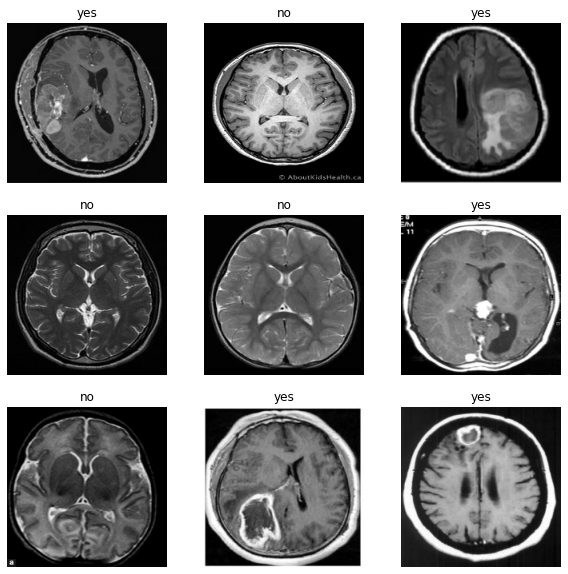

In [ ]:
from PIL import Image
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = images[i].numpy().astype("uint8")
    img = np.squeeze(img)
    imag= Image.fromarray(img)
    plt.imshow(imag , cmap='gray')
    #plt.imshow(img)
    plt.title(class_names[labels[i]])
    plt.axis("off")

Luego, tenemos dos tensores, el de las imágenes y el de las etiquetas. 
El primero tiene dimensiones (32, 200, 200, 1) que indican el tamaño del lote, las medidas en ancho y alto de las imágenes y el 1 indica la escala de grises. 
En el caso de las etiquetas solo tenemos el tamaño del lote.

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 200, 200, 1)
(16,)


## Optimización y normalización

Para evitar que se tarde tanto, guardamos las imagenes en el caché, así evitamos un cuello de botella 

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

<!-- Como las imagenes estan en un formato RGB, como se puede ver arriba,  -->

A continuación normalizamos los datos con una capa de normalización. 
Ahora los pixeles están entre 0 y 1.

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Ahora los pixeles están entre 0 y 1
print(np.min(first_image), np.max(first_image))

0.0 0.98868895


## Construcción de la red

Ahora si, comenzamos a construir la red. 

Primero agregamos la capa de normalización y después agregamos 3 capas con función de activación ReLU con 32 nodos cada una. 

Después, aplanamos la salida ya que ésta está en 2D, agregamos dos capas densas y finalmente agregamos una capa densa con 2 salidas, las 2 clases de nuestros datos.

In [ ]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255), 
  tf.keras.layers.Conv2D(32, 3, padding='same',activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3,padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3,padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes, activation='tanh')
])

Compilamos el modelo, en donde usamos la función de optimización adam. 

In [ ]:
model.compile(
  optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
  loss= 'binary_crossentropy',
  metrics=['accuracy'])

### Entrenamiento

Luego entrenamos nuestra red, usando 20 iteraciones o épocas :)





In [ ]:
epochs=20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=batch_size,
  epochs=epochs
)


Epoch 1/20
13/13 [==============================] - 13s 59ms/step - loss: 1.7365 - accuracy: 0.4307 - val_loss: 0.6733 - val_accuracy: 0.3400
Epoch 2/20
13/13 [==============================] - 0s 20ms/step - loss: 0.6178 - accuracy: 0.4455 - val_loss: 0.4456 - val_accuracy: 0.3400
Epoch 3/20
13/13 [==============================] - 0s 20ms/step - loss: 0.8627 - accuracy: 0.3911 - val_loss: 0.4952 - val_accuracy: 0.3400
Epoch 4/20
13/13 [==============================] - 0s 21ms/step - loss: 0.6047 - accuracy: 0.4356 - val_loss: 1.2725 - val_accuracy: 0.5200
Epoch 5/20
13/13 [==============================] - 0s 20ms/step - loss: 0.6489 - accuracy: 0.5891 - val_loss: 0.7014 - val_accuracy: 0.6600
Epoch 6/20
13/13 [==============================] - 0s 20ms/step - loss: 0.4536 - accuracy: 0.4752 - val_loss: 1.0282 - val_accuracy: 0.3000
Epoch 7/20
13/13 [==============================] - 0s 20ms/step - loss: 0.4967 - accuracy: 0.4851 - val_loss: 0.9113 - val_accuracy: 0.6000
Epoch 8/20
1

Este es el **resumen** de nuestro modelo hasta ahorita: 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 200, 200, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 32)        9

## Resultados

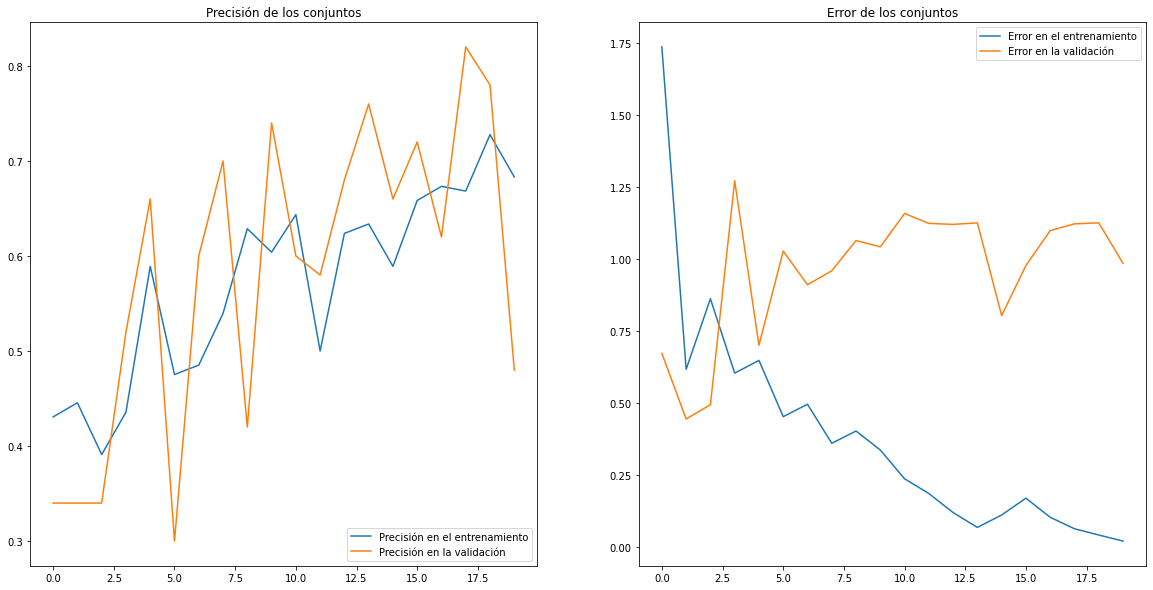

In [ ]:

def graficar(history,epochs_range):
  '''
  Graficamos la presicion en entrenamiento contra la validacion tambien con la perdida
  
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)
  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Precisión en el entrenamiento')
  plt.plot(epochs_range, val_acc, label='Precisión en la validación')
  plt.legend(loc='lower right')
  plt.title('Precisión de los conjuntos')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Error en el entrenamiento')
  plt.plot(epochs_range, val_loss, label='Error en la validación')
  plt.legend(loc='upper right')
  plt.title('Error de los conjuntos')
  plt.show()
graficar(history,epochs)


En las gráficas vemos que nuestra precisión está en 0.6, difiriendo por unos centésimales entre el de entramiento y el de validación, mientras que el error, aunque si se cruza el de validación con el de entrenamiento, parece ir con picos descendientes. 

Utilizamos una biblioteca para generar mas imagenes como, rotadas, volteadas etc.

In [ ]:
#data argumentation
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=40,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

train_gen = train_datagen.flow_from_directory(
    directory=data_dir,
    target_size=(img_height, img_height),
    color_mode="grayscale",
    #batch_size=batch_size,
    class_mode="binary",
    subset='training',
    shuffle=True,
    seed=123
)
val_gen = train_datagen.flow_from_directory(
    directory=data_dir,
    target_size=(img_height, img_height),
    color_mode="grayscale",
    #batch_size=batch_size,
    class_mode="binary",
    subset='validation',
    shuffle=True,
    seed=123
)

Found 202 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


Visualizamos los nuevos datos con la que vamos a entrenar la red

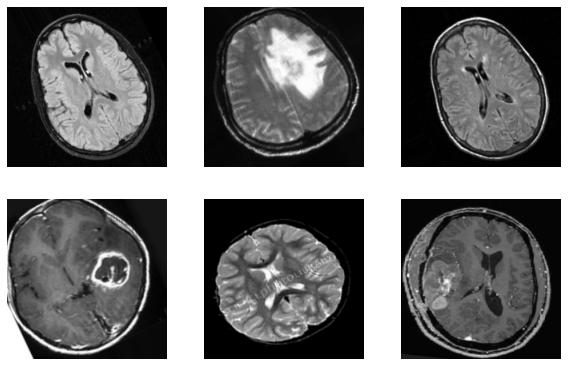

In [ ]:
plt.figure(figsize=(10, 10))
imgs, label = train_gen.next()
for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    img = imgs[i]#.astype("uint8")
    img = np.squeeze(img)
    imag= Image.fromarray(img)
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    

Con los nuevos datos entrenemos el mismo modelo, ademas de agregar un poco mas de iteraciones.

In [ ]:
epochs=30

history = model.fit(
  train_gen,
  validation_data=val_gen,
  batch_size=batch_size,
  epochs=epochs
)

Epoch 1/30
7/7 [==============================] - 3s 274ms/step - loss: 1.1522 - accuracy: 0.4802 - val_loss: 0.7731 - val_accuracy: 0.3800
Epoch 2/30
7/7 [==============================] - 1s 212ms/step - loss: 0.7326 - accuracy: 0.4901 - val_loss: 0.7102 - val_accuracy: 0.3800
Epoch 3/30
7/7 [==============================] - 1s 203ms/step - loss: 0.6780 - accuracy: 0.4455 - val_loss: 0.6672 - val_accuracy: 0.6200
Epoch 4/30
7/7 [==============================] - 1s 208ms/step - loss: 0.6872 - accuracy: 0.5792 - val_loss: 0.6712 - val_accuracy: 0.3800
Epoch 5/30
7/7 [==============================] - 1s 206ms/step - loss: 0.6741 - accuracy: 0.4604 - val_loss: 0.6707 - val_accuracy: 0.3800
Epoch 6/30
7/7 [==============================] - 1s 211ms/step - loss: 0.6751 - accuracy: 0.5644 - val_loss: 0.6645 - val_accuracy: 0.3800
Epoch 7/30
7/7 [==============================] - 1s 209ms/step - loss: 0.6746 - accuracy: 0.4802 - val_loss: 0.6657 - val_accuracy: 0.6200
Epoch 8/30
7/7 [====

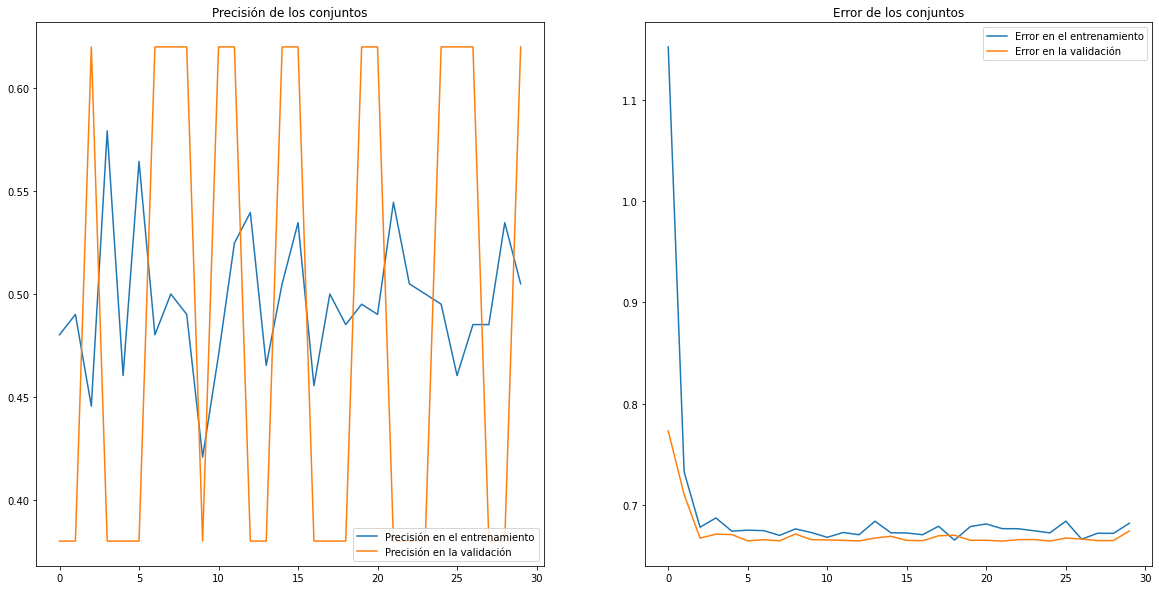

In [ ]:
graficar(history,epochs)



### Usando una red ya pre-entrenada

In [ ]:
from tensorflow.keras.applications import ResNet50, VGG19,InceptionResNetV2,NASNetLarge,EfficientNetV2M,EfficientNetV2L,EfficientNetB6

In [ ]:
train_pre = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  color_mode='rgb',
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )
val_pre = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  color_mode='rgb',
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

Found 252 files belonging to 2 classes.
Using 202 files for training.
Found 252 files belonging to 2 classes.
Using 50 files for validation.


Como existen distintas redes pre-entrenadas creamos una funcion para probar varias al mismo tiempo y tomar una desicion mas certera

In [ ]:
def entrenar_modelos(models,epochs,train,val,verbose = 0):
  '''
    Entrena los modelos dados en un diccionario con las epocas indicadas, Usando adam  y binary crossentropy
    Params:
    models: diccionario con los modelos a entrenar
    epochs: numero de epocas a entrenar
    verbose: 0,1,2, si queremos mas destalles a al hora de entrenar el modelo
  '''
  historias = {}
  for name, model in models.items():
    m =  model(
        input_shape = (200,200,3),
          include_top = False,
          weights = 'imagenet')

        
    x = keras.layers.Flatten()(m.output)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(1, activation = "sigmoid")(x)

    for layers in m.layers:
        layers.trainable = False
    m = keras.Model(m.input, x)
    m.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = "accuracy")  
    hist = m.fit(train,
                validation_data = val, 
                epochs = epochs,
                verbose=verbose)
    historias[name]= (m,hist)
    acc = hist.history['accuracy'][-1]
    val_acc = hist.history['val_accuracy'][-1]
    loss = hist.history['loss'][-1]
    val_loss = hist.history['val_loss'][-1]

    print('Nombre:{} \n acc: {}, val:{}, loss:{}, val_loss:{}'.format(name,acc,val_acc,loss,val_loss))
  return historias

Agregamos a un diccionario los modelos que tenian mejores numeros a nuestro parecer y entrenamos por 10 epocas.

In [ ]:
model = {'ResNet50':ResNet50, 'VGG19':VGG19,'InceptionResNetV2':InceptionResNetV2,'EfficientNetV2M':EfficientNetV2M,'EfficientNetV2L':EfficientNetV2L,'EfficientNetB6':EfficientNetB6}
epochs =10
hist = entrenar_modelos(model,epochs,train_pre,val_pre)

94781440/94765736 [==============================] - 0s 0us/step
Nombre:ResNet50 
 acc: 1.0, val:0.8999999761581421, loss:5.4522686696145684e-05, val_loss:1.2746155261993408
80150528/80134624 [==============================] - 0s 0us/step
Nombre:VGG19 
 acc: 1.0, val:0.8799999952316284, loss:0.0009175121667794883, val_loss:1.2014998197555542
219070464/219055592 [==============================] - 1s 0us/step
Nombre:InceptionResNetV2 
 acc: 0.6435643434524536, val:0.6600000262260437, loss:83.80386352539062, val_loss:49.185123443603516
214212608/214201816 [==============================] - 1s 0us/step
Nombre:EfficientNetV2M 
 acc: 1.0, val:0.7799999713897705, loss:0.00484065618366003, val_loss:0.872499942779541
473186304/473176280 [==============================] - 3s 0us/step
Nombre:EfficientNetV2L 
 acc: 1.0, val:0.8600000143051147, loss:0.008761441335082054, val_loss:0.7089148163795471
165249024/165234480 [==============================] - 1s 0us/step
Nombre:EfficientNetB6 
 acc: 0.995

ResNet50


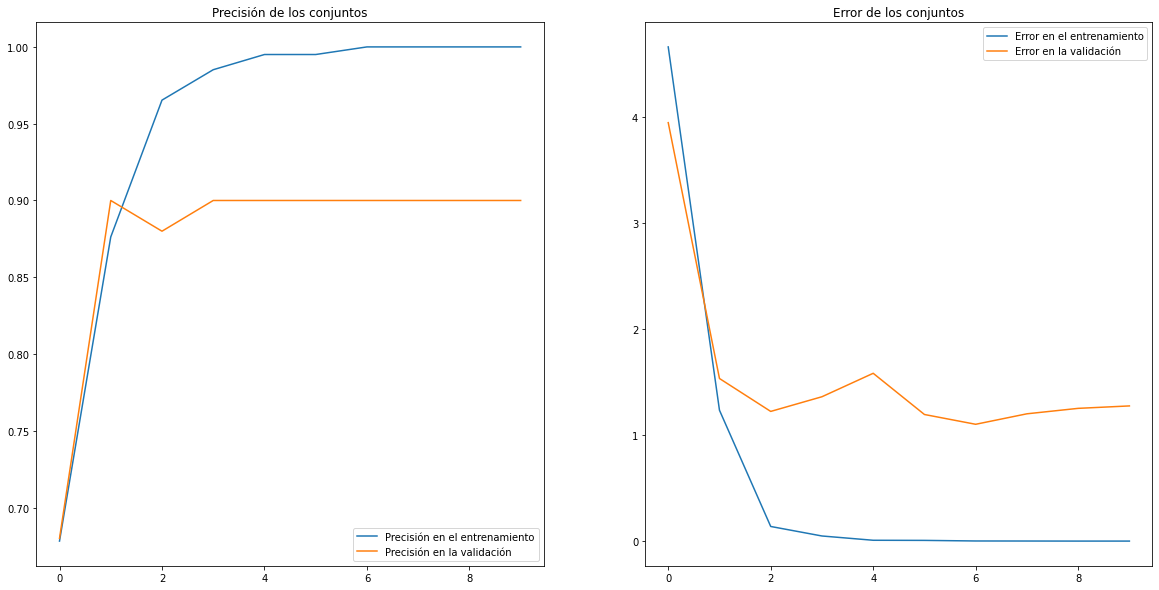

****************************************************************
VGG19


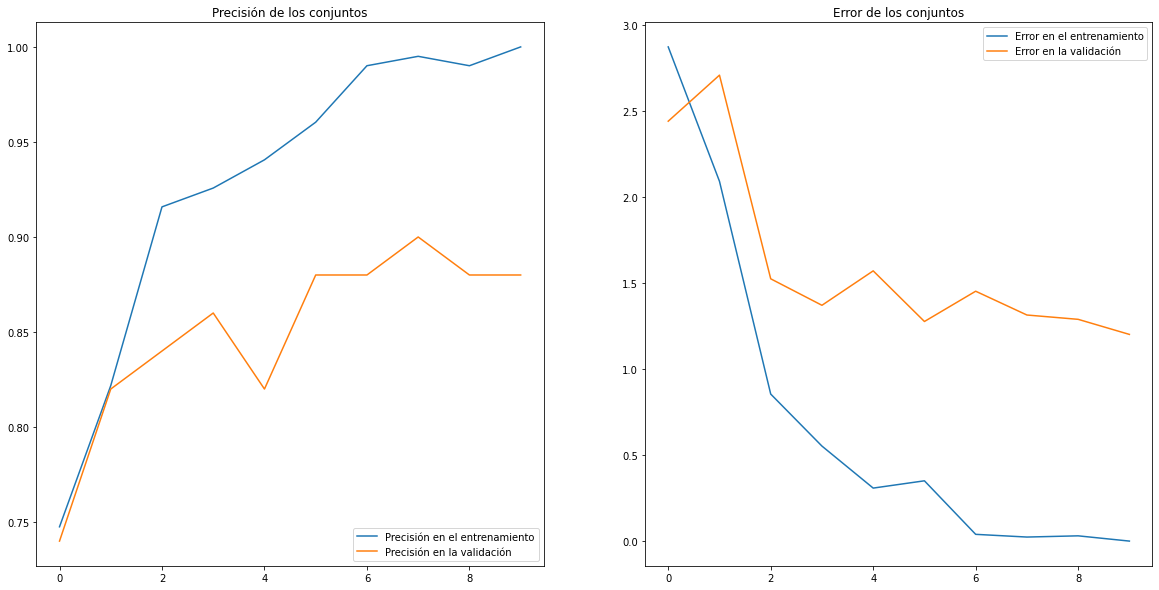

****************************************************************
InceptionResNetV2


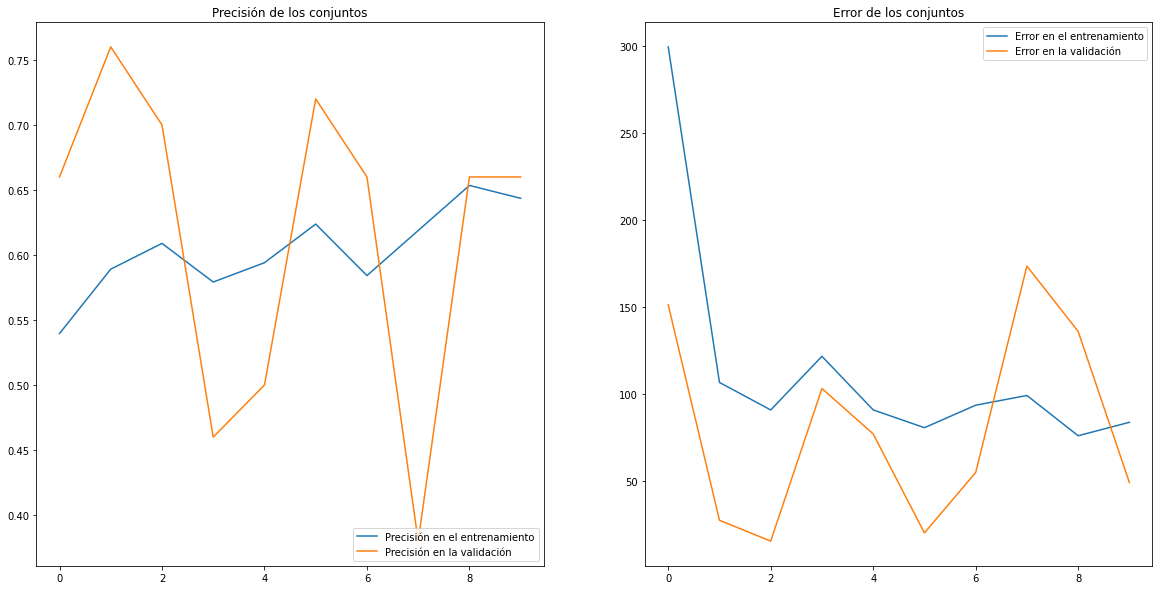

****************************************************************
EfficientNetV2M


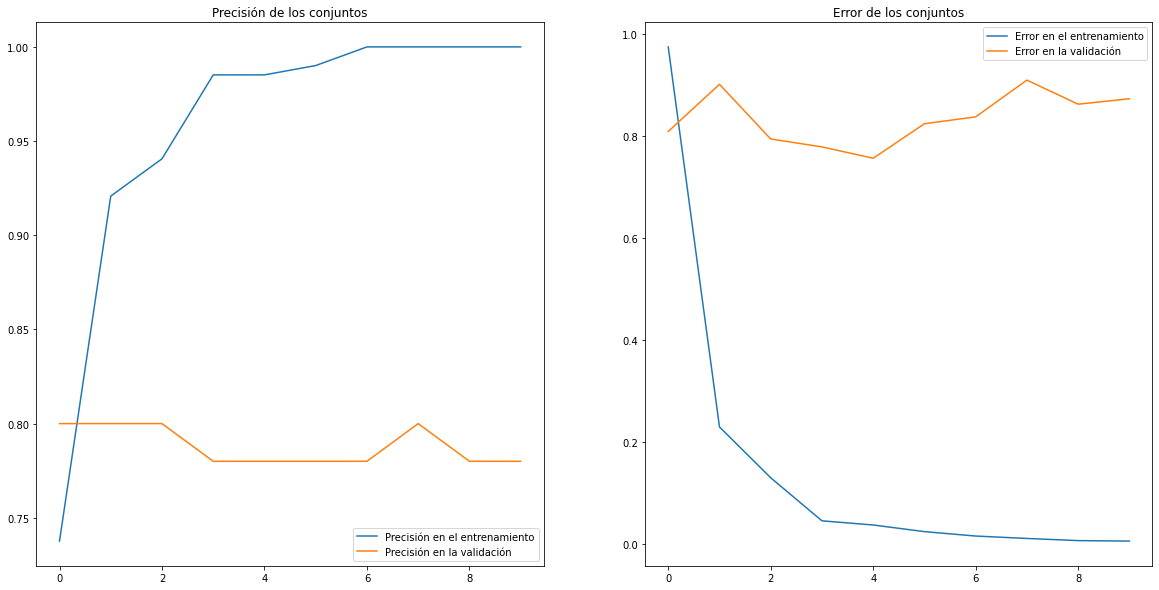

****************************************************************
EfficientNetV2L


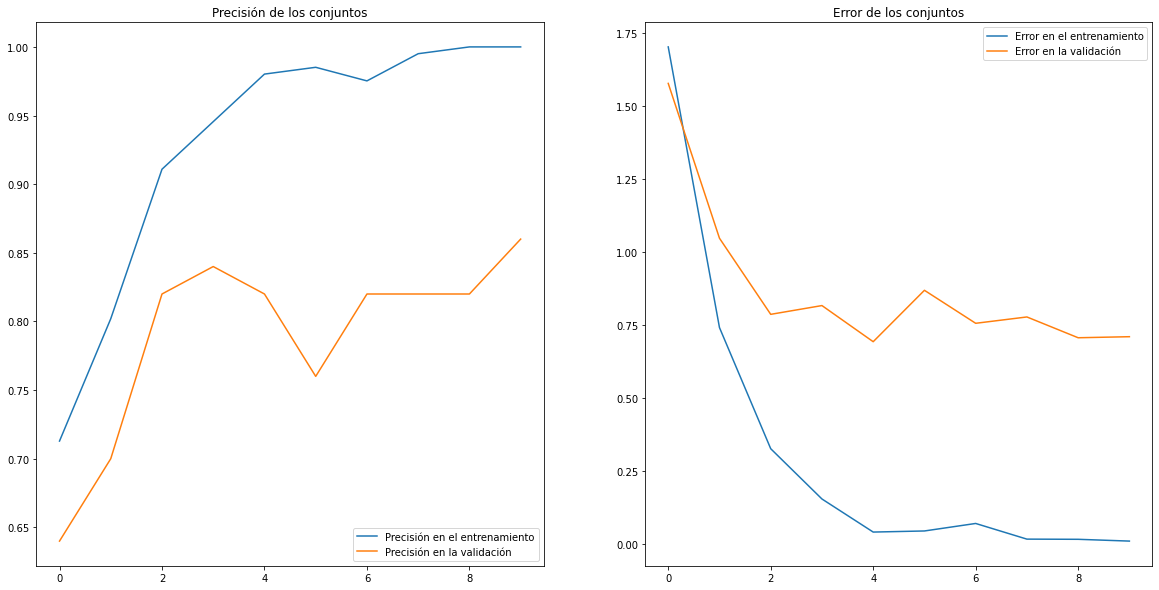

****************************************************************
EfficientNetB6


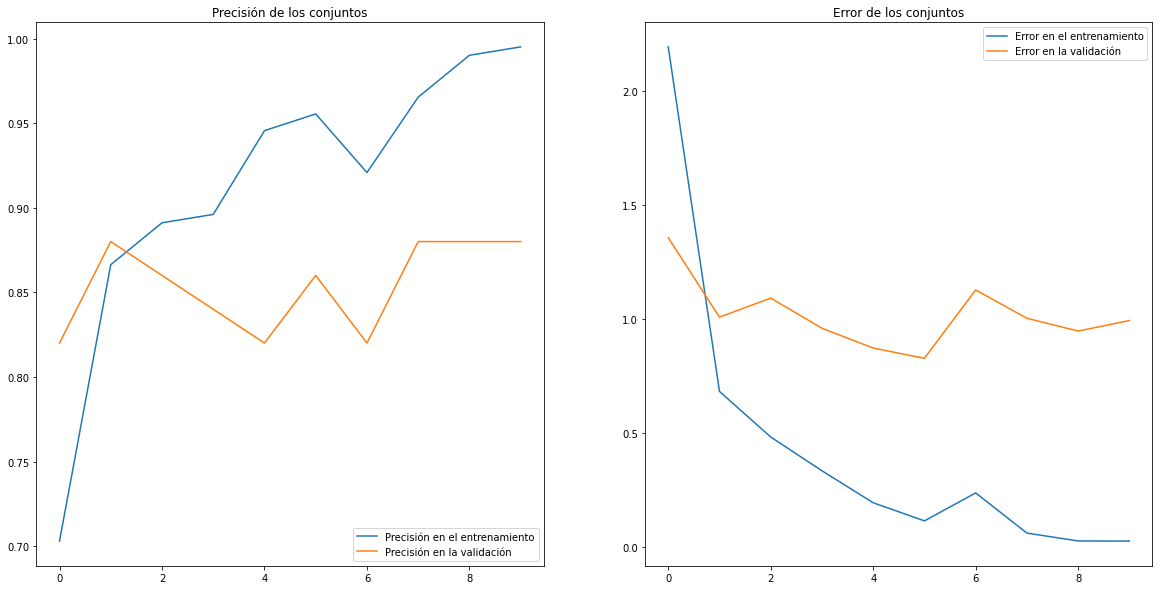

****************************************************************


In [ ]:
for name, h in hist.items():
  print(name)
  graficar(h[1],epochs)
  print('*'*64)

Dados los resultados anteriores tomamos los 3 modelos que creemos  mas prometedores. 
Entrenamos por mas epoca, para ver que como se comportan

In [ ]:
model = {'ResNet50':ResNet50, 'VGG19':VGG19,'EfficientNetB6':EfficientNetB6}
epochs =50
historias = entrenar_modelos(model,50,train_pre,val_pre)

Nombre:ResNet50 
 acc: 1.0, val:0.8999999761581421, loss:1.9468543541734107e-06, val_loss:1.1020057201385498
Nombre:VGG19 
 acc: 0.9900990128517151, val:0.800000011920929, loss:0.033856507390737534, val_loss:2.464611530303955
Nombre:EfficientNetB6 
 acc: 0.9950494766235352, val:0.8799999952316284, loss:0.008758371695876122, val_loss:1.3613494634628296


ResNet50


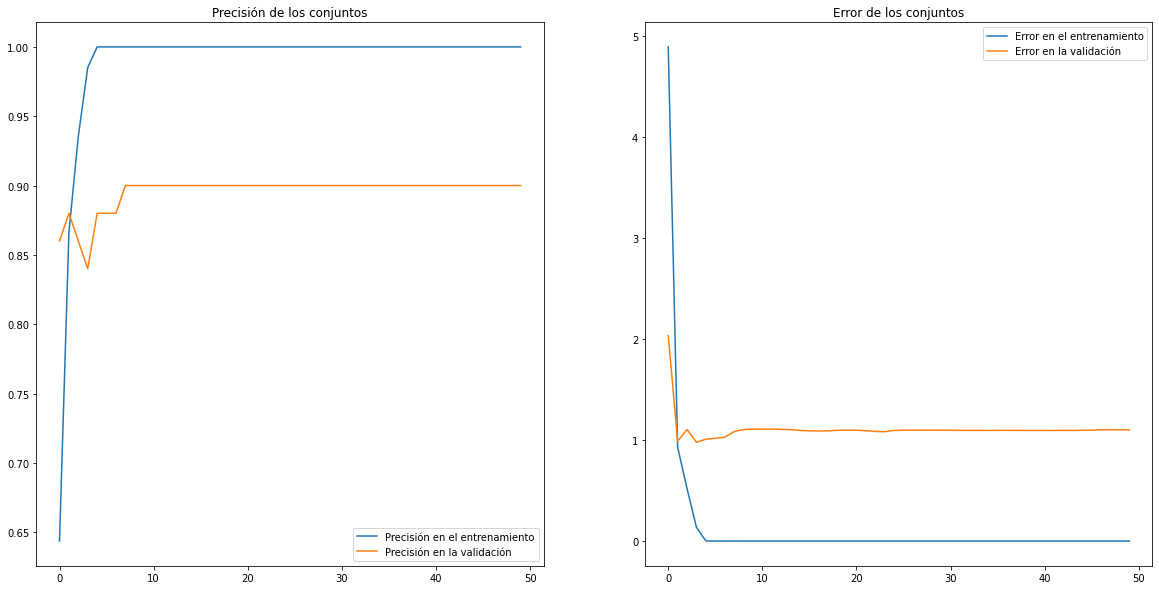

****************************************************************
VGG19


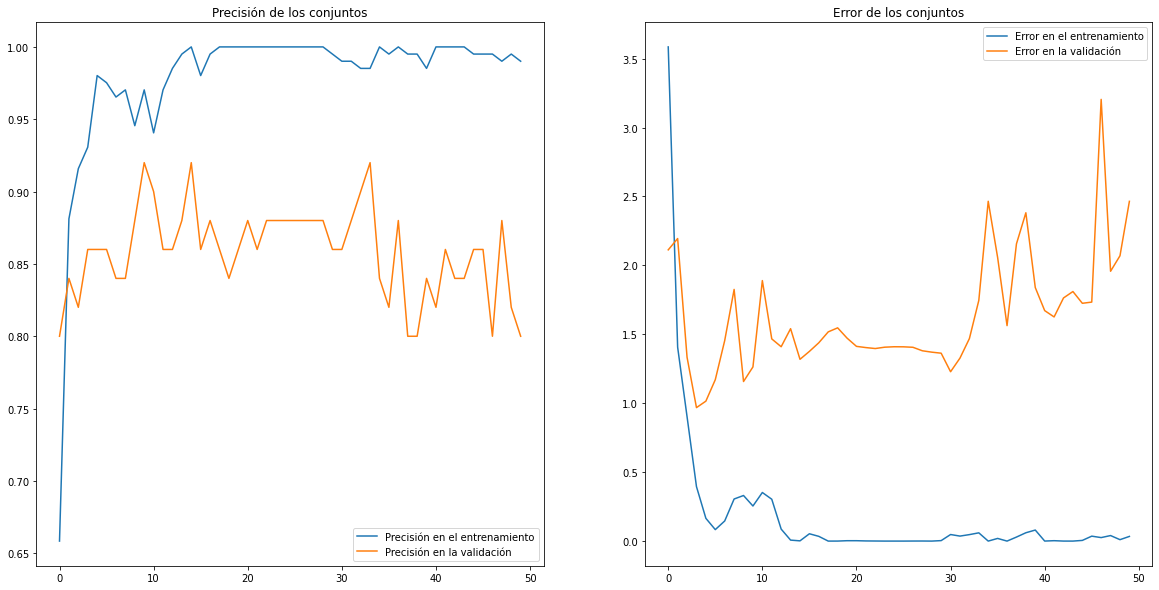

****************************************************************
EfficientNetB6


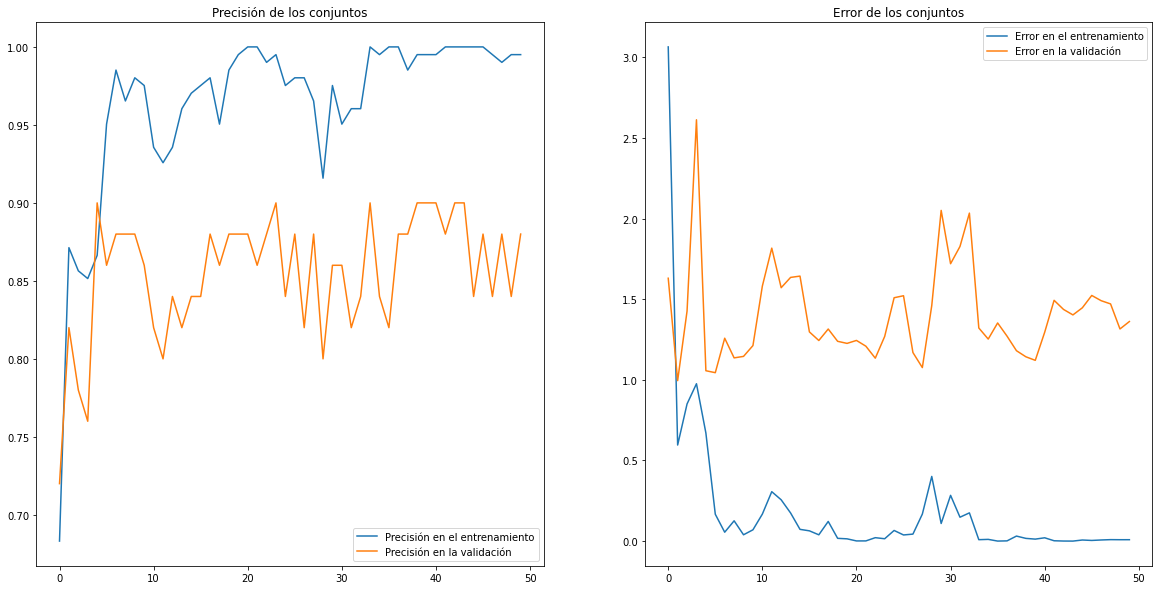

****************************************************************


In [ ]:
for name, h in historias.items():
  print(name)
  graficar(h[1],epochs)
  print('*'*64)

Vemos que los modelos tienen buenos resultados pero parece que hay un poco de sobre entrenamiento.

Por lo que tomaremos los modelos VGG19,EfficientNetB6, y los entrenaremos con otros datos, donde las imagenes estan volteadas, rotadas etc.

In [ ]:
#data argumentation
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=40,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

train_pre_gen = train_datagen.flow_from_directory(
    directory=data_dir,
    target_size=(img_height, img_height),
    color_mode="rgb",
    #batch_size=batch_size,
    class_mode="binary",
    subset='training',
    shuffle=True,
    seed=123
)
val_gen_pregen = train_datagen.flow_from_directory(
    directory=data_dir,
    target_size=(img_height, img_height),
    color_mode="rgb",
    #batch_size=batch_size,
    class_mode="binary",
    subset='validation',
    shuffle=True,
    seed=123
)

Found 202 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [ ]:
model = {'VGG19':VGG19,'EfficientNetB6':EfficientNetB6}
epochs= 50
historias = entrenar_modelos(model,epochs,train_pre_gen,val_gen_pregen)

Nombre:VGG19 
 acc: 0.9554455280303955, val:0.8199999928474426, loss:0.1495305597782135, val_loss:0.4054639935493469
Nombre:EfficientNetB6 
 acc: 0.5495049357414246, val:0.3799999952316284, loss:1.5429964065551758, val_loss:3.2971391677856445


VGG19


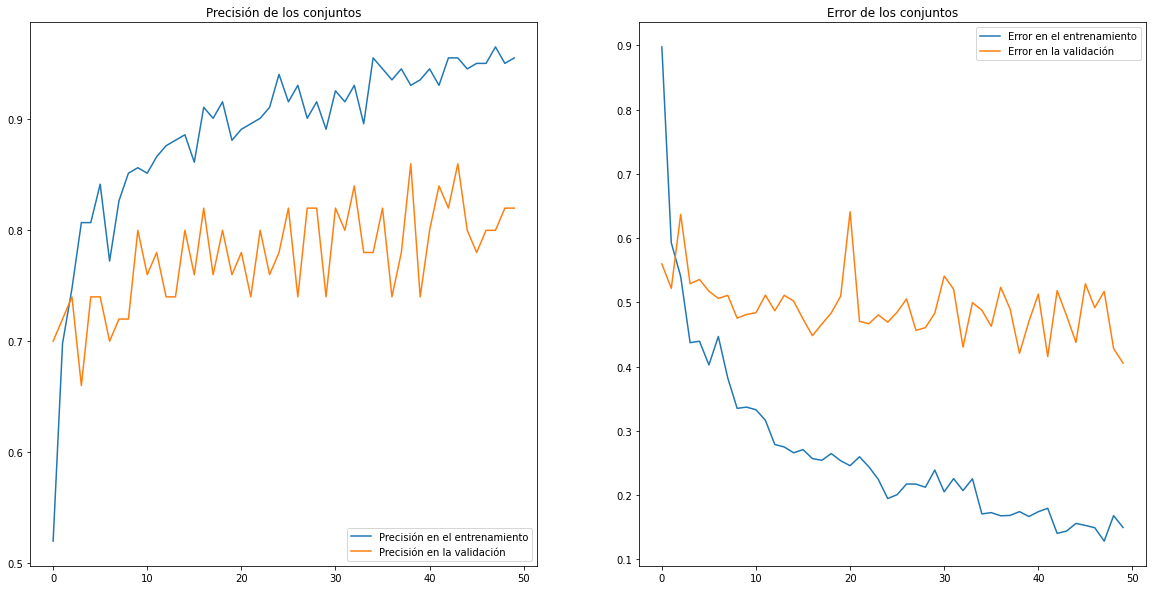

****************************************************************
EfficientNetB6


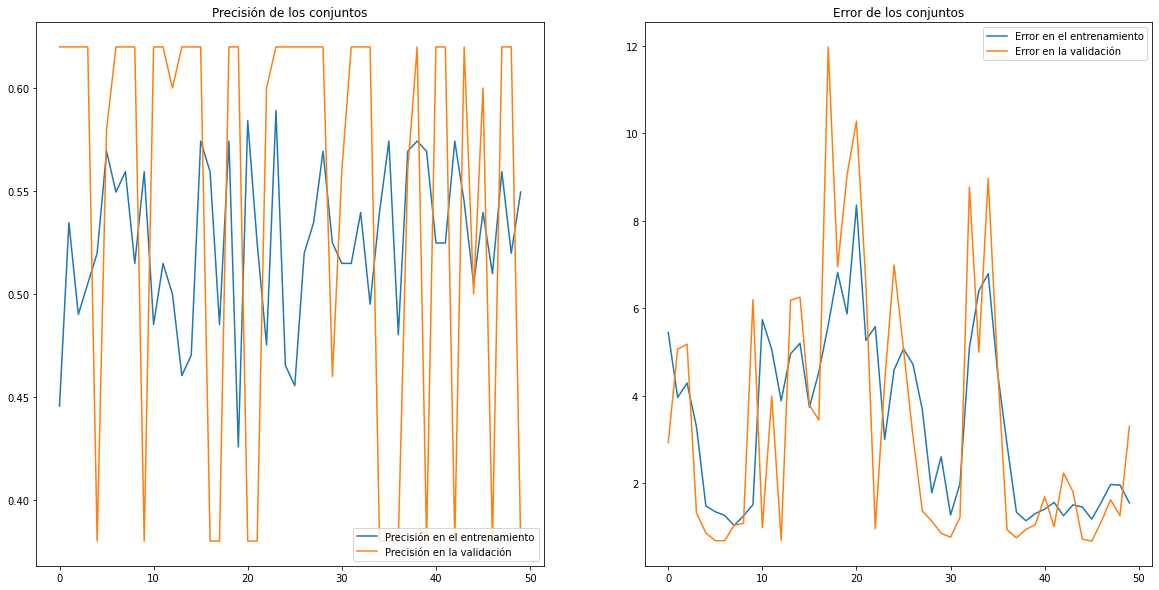

****************************************************************


In [ ]:
for name, h in historias.items():
  print(name)
  print(h[1])
  graficar(h[1],epochs)
  print('*'*64)

Observamos que estos nuevos datos los resultados cambian un poco con respecto los anteriores datos.

Entonces entrenamos los mismos modelos con los datos originales y ver cuales son los resultdos con el modelo entrenado con los tipos de datos. (originasles y los modificados)

In [ ]:
model_pre1 = historias['VGG19'][0]
epochs = 50
hist_1 = model_pre1.fit(train_pre,validation_data = val_pre, 
                           epochs = epochs)

Epoch 1/50
13/13 [==============================] - 2s 135ms/step - loss: 6.2316 - accuracy: 0.8366 - val_loss: 7.0191 - val_accuracy: 0.8200
Epoch 2/50
13/13 [==============================] - 2s 118ms/step - loss: 3.0201 - accuracy: 0.8861 - val_loss: 5.2575 - val_accuracy: 0.8600
Epoch 3/50
13/13 [==============================] - 2s 118ms/step - loss: 1.7803 - accuracy: 0.9505 - val_loss: 1.7129 - val_accuracy: 0.8800
Epoch 4/50
13/13 [==============================] - 2s 118ms/step - loss: 0.3368 - accuracy: 0.9653 - val_loss: 1.9931 - val_accuracy: 0.9200
Epoch 5/50
13/13 [==============================] - 2s 119ms/step - loss: 0.3637 - accuracy: 0.9752 - val_loss: 2.1718 - val_accuracy: 0.9200
Epoch 6/50
13/13 [==============================] - 2s 118ms/step - loss: 0.0835 - accuracy: 0.9851 - val_loss: 1.6918 - val_accuracy: 0.9200
Epoch 7/50
13/13 [==============================] - 2s 117ms/step - loss: 0.1826 - accuracy: 0.9901 - val_loss: 1.4299 - val_accuracy: 0.9000
Epoch 

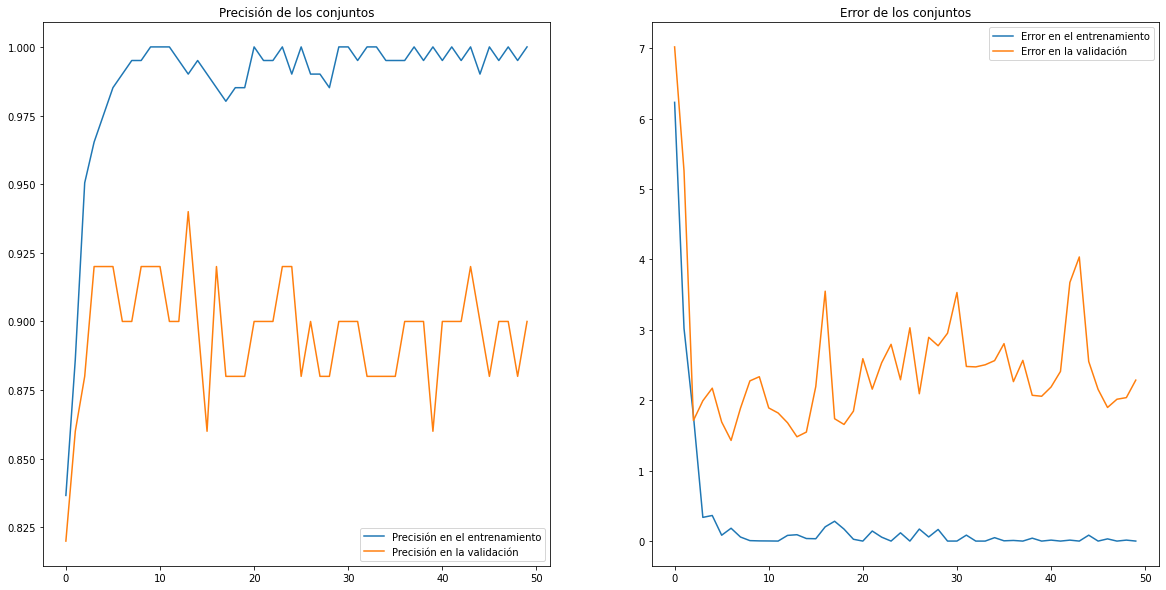

In [ ]:
graficar(hist_1,epochs)

In [ ]:
model_pre2 = historias['EfficientNetB6'][0]
epochs = 50
hist2 = model_pre2.fit(train_pre,validation_data = val_pre, 
                           epochs = epochs)

Epoch 1/50
13/13 [==============================] - 14s 462ms/step - loss: 0.6713 - accuracy: 0.7624 - val_loss: 0.8102 - val_accuracy: 0.8000
Epoch 2/50
13/13 [==============================] - 2s 177ms/step - loss: 0.3385 - accuracy: 0.8713 - val_loss: 0.8209 - val_accuracy: 0.8000
Epoch 3/50
13/13 [==============================] - 2s 177ms/step - loss: 0.4013 - accuracy: 0.8960 - val_loss: 0.6910 - val_accuracy: 0.8200
Epoch 4/50
13/13 [==============================] - 2s 178ms/step - loss: 0.2757 - accuracy: 0.9010 - val_loss: 0.8282 - val_accuracy: 0.8600
Epoch 5/50
13/13 [==============================] - 2s 178ms/step - loss: 0.2461 - accuracy: 0.9158 - val_loss: 0.9754 - val_accuracy: 0.8400
Epoch 6/50
13/13 [==============================] - 2s 178ms/step - loss: 0.1714 - accuracy: 0.9455 - val_loss: 0.7440 - val_accuracy: 0.8600
Epoch 7/50
13/13 [==============================] - 2s 179ms/step - loss: 0.0876 - accuracy: 0.9802 - val_loss: 0.6907 - val_accuracy: 0.8800
Epoch

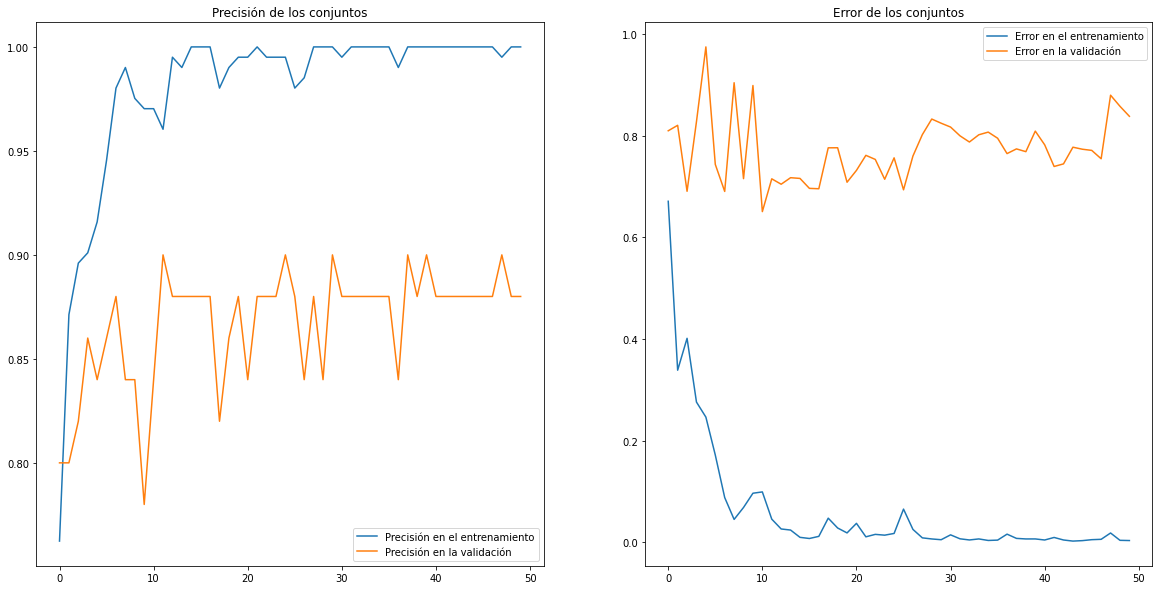

In [ ]:
graficar(hist2,epochs)

Con los datos anteriores podemos concluir que EfficientNetB6 tiene un claro sobre entrenamiento, al igual que VGG19, se puede apreciar  gracias a las graficas que nos muestran.
